### MTH9866 Modeling and Market Making in Foreign Exchange

#### Homework Assignment 6

#### ShengQuan Zhou

### Question 1

In class we looked at Gaussian copulas for pricing two-asset derivatives. We talked about using that model to price cross-pair options based on the two USD-pair option markets, calibrating the Gaussian copula correlation parameter such that the model reproduces the ATM cross option price.

When we do that, the model tends to underprice the butterfly – ie the implied volatility smile that comes out of the model is lower than the market. We said that was due to the fact that the model does not include any premium for stochastic correlation, which it should because correlation is not constant.

A stochastic correlation only affects the value of a derivative if its exposure to that correlation is non-linear. Let’s consider a specific case of the Gaussian copula to examine that: one where the RR and BF of the USD pairs is zero. In that case, their pricing is just Black-Scholes pricing, and if we assume a constant correlation, the pricing of the cross option is Black-Scholes with an implied volatility
$$
\sigma_x = \sqrt{\sigma_1^2 + \sigma_2^2 -2 \rho\sigma_1\sigma_2}.
$$

Calculate the “gamma” of the cross option price with respect to the correlation parameter $\rho$. Assume a market where the two USD-pair spots are 1, interest rates are zero, time to expiration is 0.5y, the USD-pair volatilities are both equal to 10%, and the correlation is +25%, and plot the correlation gamma as a function of strike for the cross-pair options.

Discuss the qualitative impact stochastic correlation should have on the cross-pair implied volatilities based on that plot.

#### Solution:

In Black-Scholes, the second derivative of option price with respect to volatility (up to a constant spot factor)
$$
\text{Vega} =\frac{\partial V}{\partial \sigma}= e^{-q\tau} \sqrt{\frac{\tau}{2\pi}}e^{-\frac{d_+^2}{2}}, \quad \text{Vol Gamma}=\frac{\partial^2 V}{\partial \sigma^2} = e^{-q\tau}\sqrt{\frac{\tau}{2\pi}}e^{-\frac{d_+^2}{2}}\frac{d_+d_-}{\sigma} = \text{vega}\times \frac{d_+d_-}{\sigma}.
$$
Thus,
\begin{eqnarray}
\frac{\partial V}{\partial \rho} &=& \text{Vega}\times\frac{\partial \sigma}{\partial \rho}
=-\text{Vega}\times\frac{\sigma_1\sigma_2}{\sigma} = - e^{-q\tau} \sqrt{\frac{\tau}{2\pi}}e^{-\frac{d _ +^2}{2}}\frac{\sigma_1\sigma_2}{\sigma} \\
\frac{\partial^2 V}{\partial^2 \rho} &=& \frac{\partial \text{Vega}}{\partial \rho}\times\frac{\partial \sigma}{\partial \rho} + \text{Vega}\times\frac{\partial^2 \sigma}{\partial \rho^2} = \text{Vol Gamma}\times\left(\frac{\partial \sigma}{\partial \rho}\right)^2 + \text{Vega}\times\frac{\partial^2 \sigma}{\partial \rho^2} = \text{Vega}\times\left(\frac{d _ +d _ - -1}{\sigma}  \right)\left(\frac{\sigma_1\sigma_2}{\sigma}\right)^2
\end{eqnarray}


In [11]:
import cmath
import math
from scipy.stats import norm
import numpy as np

In [20]:
def bs_vega(S,K,T,r,q,v):
    d1 = (math.log(S/K)+(r-q+v*v/2.)*T)/(v*math.sqrt(T))
    return S * math.sqrt(T)*norm.pdf(d1)

def bs_rhoGamma(S,K,T,r,q,v1,v2,rho):
    v = math.sqrt(v1*v1+v2*v2-2*rho*v1*v2)
    v1v2v = v1*v2/v
    d1 = (math.log(S/K)+(r-q+v*v/2.)*T)/(v*math.sqrt(T))
    d2 = d1-v*math.sqrt(T)
    return bs_vega(S,K,T,r,q,v)*v1v2v*v1v2v*(d1*d2-1)/v

In [21]:
S = 1
T = 0.5
r = 0
q = 0
v1 = 0.1
v2 = 0.1
rho = 0.25

def func(K):
    return bs_rhoGamma(S,K,T,r,q,v1,v2,rho)

vfunc = np.vectorize(func)

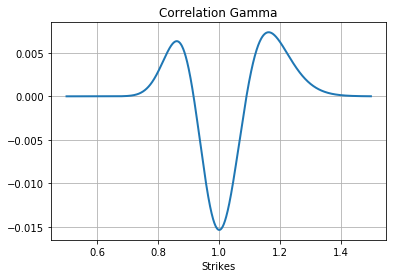

In [28]:
import matplotlib.pyplot as plt
x = np.arange(0.5, 1.5, 0.001)
y = vfunc(x)
plt.plot(x, y, lw=2)
plt.xlabel('Strikes')
plt.title('Correlation Gamma')
plt.grid(True)
plt.show()

#### Comments

The correlation gamma is negative for ATM cross options and positive for OTM cross options. This means that any volatility in the correlation parameter will tend to push down the prices of ATM cross options, and push up the prices of OTM cross options, thereby increasing the cross butterfly.

The intuition here: One can buy an ATM cross option, then trade enough of a slightly-OTM cross option to make the correlation sensitivity (the first-order derivative) zero. This realizes a payoff vs correlation that always loses money as correlation moves around – just like with a delta-hedged vanilla option and regular gamma, or the vega gamma/vega dspot as the source of skew and smile. As a consequence, one always tend to sell that position.

### Question 2

Describe the market dynamic that is most important for knockout out pricing, and compare that to the market dynamic that is the most important for volatility swap pricing.

For each, explain why that market dynamic is important to the pricing.

#### Answer:

Knockout pricing is most sensitive to the risk reversal beta. For knockouts, one can construct a "semi-static" hedge of vanilla options:
- long a down-and-out knockout call;
- sell the regular call (same strike as the knockout);
- buy a put whose strike is the knockout strike “reflected” through the barrier: $\frac{B_2}{K}$. 

> That two-vanilla portfolio hedges almost all the market risk unless the barrier is hit, where one needs to unwind it. The cost of unwinding that two-vanilla portfolio when spot is at the barrier is mostly a function of risk reversal, because at that point the call and put are (roughly) equally out-of-the-money. That means their net sensitivity to ATM vol is small, as is their net sensitivity to butterfly. That portfolio is sensitive only to the level of risk reversal. The expected level of risk reversal is determined by how much we think risk reversal will have moved while spot moved down to the barrier, which is basically our measure of risk reversal beta: the regression coefficient of moves in risk reversal with moves in spot.

Volatility swap pricing is most sensitive to realized volatility of implied volatility. For volatility swaps, the natural hedge:

- long volatility swap
- short variance swap, which can be replicated with vanilla options in a model-free way (caveats: this doesn’t work if there are jumps, and gives exposure to implied vol extrapolation behavior). 

> The volatility swap looks like a square-root payoff against the variance swap, which is non-linear dependence. That means one needs to keep rebalancing the notional of the short variance swap, much like one would need to keep rebalancing the notional of a delta hedge against a short option position. And much the same way, one expects to lose money doing so, as it’s a short gamma position (in the case of a volatility swap it’s short gamma to the variance swap fair strike; in the case of a vanilla option it’s short gamma to the underlying spot). One then expects to lose money over time running a long volatility swap position, and one gets compensated for that by being able to enter the volatility swap at a fair strike that’s less than the square root of the variance swap fair strike.  The discount in fair strike depends on the realized volatility of the variance swap fair strike, which is roughly the same as realized volatility of implied volatility.

### Question 3

Consider a dual digital option that pays \$1 if EURUSD is above a strike $K_1$ and GBPUSD is above a strike $K_2$. All discount rates are zero. The price of the EURUSD European digital option (paying \$1 if EURUSD is above $K_1$) is 65% and the price of the GBPUSD European digital option (paying \$1 if GBPUSD is above $K_2$) is 30%.

Plot the price of the dual digital option priced under a Gaussian copula model, for correlation parameter ranging from -100% to +100%. Qualitatively explain the behavior of the price sensitivity to correlation.

Remembering that the main dynamic impacting the knockout price is risk reversal beta, qualitatively explain the behavior of the knockout price with $\alpha$.

#### Solution:

$$
V = \int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty} P(S_1(x_1), S_2(x_2))f_{12}(x_1,x_2)dx_1 dx_2,
$$
where $S_1(x) = F_1^{-1}(N(x)), S_2(x) = F_2^{-1}(N(x))$ under a Gaussian copula model
$$
f_{12}(x_1,x_2) = \frac{2}{2\pi\sqrt{1-\rho^2}}e^{-\frac{x_1^2+x_2^2-2\rho x_1 x_2}{2(1-\rho^2)}}.
$$
For a European joint digital option, $P(S_1,S_2)=\Theta(S_1-K_1)\Theta(S_2-K_2)$. Thus,
$$
V = \int_{X_1}^{+\infty}\int_{X_2}^{+\infty} f_{12}(x_1,x_2)dx_1 dx_2,
$$
where $X_1 = N^{-1}(F_1(K_1))=N^{-1}(1-0.65)\approx -0.3853$, $X_2=N^{-1}(F_2(K_2))=N^{-1}(1-0.3)\approx 0.5244$.

In [41]:
def dualDigitalOptionPrice(rho):
    lowerBound = np.array([-0.3853, 0.5244])
    upperBound = np.array([10,10])
    mu = np.array([0,0])
    cov = np.array([[1,rho],[rho,1]])
    p,i = mvn.mvnun(lower=lowerBound,upper=upperBound,means=mu,covar=cov)
    return p

vDualDigitalOptionPrice = np.vectorize(dualDigitalOptionPrice)

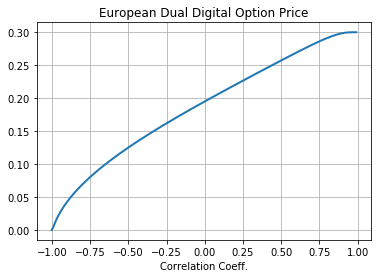

In [42]:
rho = np.arange(-1, 1, 0.01)
price = vDualDigitalOptionPrice(rho)
plt.plot(rho, price, lw=2)
plt.xlabel('Correlation Coeff.')
plt.title('European Dual Digital Option Price')
plt.grid(True)
plt.show()

#### Comments

The dual option price increases with correlation. The intuition behind: if the first asset is above the strike, when the correlation is positive, it’s more likely for the second asset to be above the barrier as well.

When correlation=100%, the price should be the minimum of the two European digital prices($=0.3$). When correlation=0%, the price should be the product of the two European digital prices ($= 0.65\times 0.3= 0.195$). When the correlation is -100% the price should be zero, as if one asset is above its strike, the second must be below.